In [1]:
import numpy as np
import pandas as pd

from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor

from envs.bess_env import BatteryEnv
from utils.csv_handler import load_price_data
from utils.plot_handler import plot_bess_rollout
from utils.eval_handler import evaluate_financials

In [2]:
df, price_series, timestamps = load_price_data(
    csv_path   = "../data/raw/dayahead_2024_11.csv",
    resolution = "15min",
)

df_week = df.loc["2024-11-01":"2024-11-07"] # 672 steps (1 week)
price_week = df_week["Day Ahead Auktion"].values.astype(np.float32)
timestamps_week = df_week.index

print(len(price_week), "time steps in a week (should be 672)")
print("Week from", timestamps_week[0], "to", timestamps_week[-1])

672 time steps in a week (should be 672)
Week from 2024-11-01 00:00:00+01:00 to 2024-11-07 23:45:00+01:00


In [4]:
# Create BatteryEnv with 15-minute step and 21 discrete actions in [-p_max, +p_max]
env = BatteryEnv(
    price_series=price_week,
    demand_series=None,
    timestamps=timestamps_week,
    dt_hours=0.25,              # 15 min
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=True,  # required for DQN
    random_seed=42,
)

# Wrap with Monitor for SB3 (logs episode stats)
env = Monitor(env)

model = DQN(
    "MlpPolicy",
    env,
    learning_rate=1e-3,
    buffer_size=50_000,
    learning_starts=1_000,
    batch_size=64,
    gamma=0.99,
    tau=1.0,
    train_freq=4,
    target_update_interval=1_000,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    exploration_fraction=0.3,
    verbose=1,
)

model.learn(
    total_timesteps=100_000,
    log_interval=10,
    progress_bar=True,
)

print("DQN training completed.")

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 99,946/100,000  [ 0:01:53 < 0:00:01 , 839 it/s ]

DQN training completed.


In [5]:
# Use a "fresh" env for evaluation (same config, different seed)
eval_env = BatteryEnv(
    price_series=price_week,
    demand_series=None,
    timestamps=timestamps_week,
    dt_hours=0.25,
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=True,
    random_seed=123,   # different seed for initial SoC
)

obs, info = eval_env.reset()

soc_list = []
soh_list = []
reward_list = []
price_true_list = []
action_list_kW = []

revenue_list = []
deg_cost_list = []
penalty_list = []

n_steps = len(price_week)   # one full week

for t in range(n_steps):
    # Let DQN choose a discrete action (integer index)
    action, _ = model.predict(obs, deterministic=True)   # action is int for Discrete env

    obs, reward, terminated, truncated, info = eval_env.step(action)

    # Store time series
    soc_list.append(obs[0])                         # SoC
    soh_list.append(obs[1])                         # SoH
    reward_list.append(reward)
    price_true_list.append(info["price_true"])
    action_list_kW.append(float(eval_env.discrete_action_values[action]))

    # Financial components
    revenue_list.append(info["revenue_eur"])
    deg_cost_list.append(info["deg_cost_eur"])
    penalty_list.append(info["penalty_eur"])

    if terminated or truncated:
        print(f"Episode finished at step {t}")
        break

print("Rollout steps:", len(soc_list))


Episode finished at step 671
Rollout steps: 672


=== Financial Summary ===
Total revenue    (EUR): 14.379
Degradation cost (EUR): 6.303
Penalty cost     (EUR): 0.000
Net profit       (EUR): 8.076


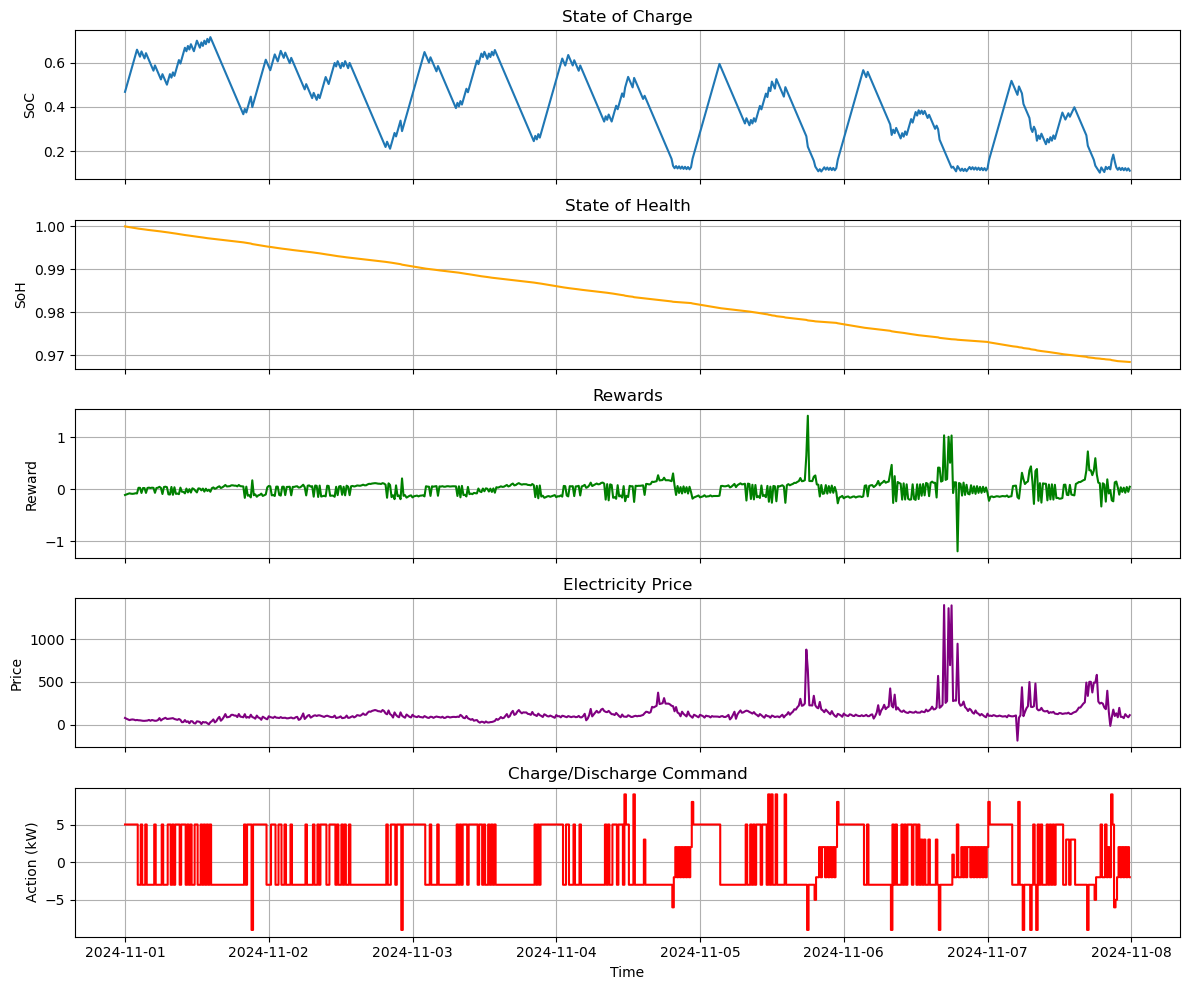

In [6]:
results = evaluate_financials(
    revenue_list,
    deg_cost_list,
    penalty_list,
)

plot_bess_rollout(
    soc_list=soc_list,
    soh_list=soh_list,
    reward_list=reward_list,
    price_list=price_true_list,
    action_list=action_list_kW,
    timestamps=timestamps_week[:len(soc_list)],
)